In [63]:
### 모듈 로딩

import torch
import torch.nn as nn
import torch.nn.functional as f
import cv2
from torchinfo import summary

In [64]:
### 데이터 준비
filename = '../datas/smudgeyyy.jpg'

In [65]:
#COLOR IMG(3차원)

imgnp = cv2.imread(filename=filename)/255
print(imgnp.shape, imgnp.ndim)

imgnp = cv2.resize(imgnp, (50,50))
print(imgnp.shape, imgnp.ndim)

(608, 1080, 3) 3
(50, 50, 3) 3


In [66]:
# GRAYSCALED IMAGE(2차원)

grayimg = cv2.imread(filename=filename, flags = cv2.IMREAD_GRAYSCALE)/255
grayimg = cv2.resize(grayimg,(50,50))
print(grayimg.shape, grayimg.ndim)

(50, 50) 2


In [67]:
#np -> Tensorize
imgts = torch.FloatTensor(imgnp)
grayts = torch.FloatTensor(grayimg)

In [68]:
print(f'[COLORIMAGE TENSORIZED]: {imgts.shape}, {imgts.ndim}D')
print(f'[GRAYSCALEDIMAGE TENSORIZED]: {grayts.shape}, {grayts.ndim}D')

[COLORIMAGE TENSORIZED]: torch.Size([50, 50, 3]), 3D
[GRAYSCALEDIMAGE TENSORIZED]: torch.Size([50, 50]), 2D


In [69]:
## pytorch image data 형식 (C, W, H)

imgts = imgts.permute(2,0,1)
grayts = grayts.unsqueeze_(dim=0)#차원부터 늘리기

In [70]:
print(f'[COLORIMAGE TENSORIZED]: {imgts.shape}, {imgts.ndim}D')
print(f'[GRAYSCALEDIMAGE TENSORIZED]: {grayts.shape}, {grayts.ndim}D')

[COLORIMAGE TENSORIZED]: torch.Size([3, 50, 50]), 3D
[GRAYSCALEDIMAGE TENSORIZED]: torch.Size([1, 50, 50]), 3D


### CNN MODEL LAYER 살펴보기


In [71]:
## 이미지 데이터로 con2d
# [1] 흑백 이미지
conLayer = nn.Conv2d(in_channels=1, out_channels = 5, kernel_size=3, stride=1, padding = 0) #Valid padding, kernel = 3*3 => 입/출력 shape 다름
conLayer2 = nn.Conv2d(in_channels=5,out_channels= 3, kernel_size= 3, stride=1, padding = 'same') #Same padding, kernel 3*3  => 입/출력 shape 동일
                                                                                            #커널 크기가 커지면 padding도 커져야 함(소실되는 데이터가 많아지기 때문,,)padding 매개변수 same이면 same padding, 패딩 크기를 조절하고 싶으면 정수(또는 정수로 이루어진 튜플)
conLayer2

Conv2d(5, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)

똑같은 데이터를 주더라도 padding이나 stride(몇 칸씩 이동할 건지) 가 다르면 shape가 달라진다.
stride값이 2면 종으로 2, 횡으로 2칸씩 이동-> 바로 아랫줄을 읽을 수 없다.

In [72]:
output = conLayer(grayts)
print(output.shape, output.ndim)

out2 = conLayer2(output)
print(out2.shape)

torch.Size([5, 48, 48]) 3
torch.Size([3, 48, 48])


### POOLING LAYER

In [73]:
# pooling layer : conv 층에서 추출한 특징을 다운 샘플링 진행
# 결과 shape : height weight 줄어듦. channel은 그대로.
pool1 = nn.MaxPool2d(kernel_size=3)
pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

## convXD + AF => F.relu
relu1 = f.relu(input = output)
print(relu1.shape)

relu2 = f.relu(conLayer2(relu1)) #convLayer-> 활성화 함수 -> conLayer2 -> 활성화 함수 2
relu2.shape

torch.Size([5, 48, 48])


torch.Size([3, 48, 48])

In [74]:
#2번째 conv2D+AF 결과인 피처맵 전달
fm1 = pool1(relu2)
fm1.shape

torch.Size([3, 16, 16])

### 추출된 feature map 확인하기

In [76]:
## Conv2D + Conv2D + Pooling
print(f'input ==> grayts: {grayts.shape}')
output1 = conLayer(grayts)
relu1 = f.relu(input=output1)
print(relu1.shape)

output2 = conLayer2(relu1)
relu2 = f.relu(input=output2)
print(relu2.shape)

mp1 = pool1(relu2)
print(f'[MP1] {mp1.shape}')

input ==> grayts: torch.Size([1, 50, 50])
torch.Size([5, 48, 48])
torch.Size([3, 48, 48])
[MP1] torch.Size([3, 16, 16])


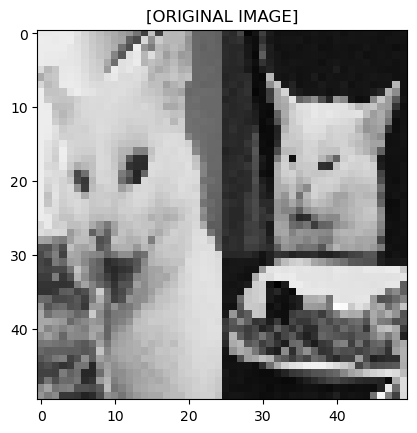

In [79]:
# 시각화
import matplotlib.pyplot as plt

#입력 그림
#plt.imshow(grayts[0], cmap='gray')

# 차원 변경
gray_img = grayts.squeeze(0)
plt.imshow(X=gray_img, cmap= 'gray')
plt.title ('[ORIGINAL IMAGE]')
plt.show()

[Fist Layer]


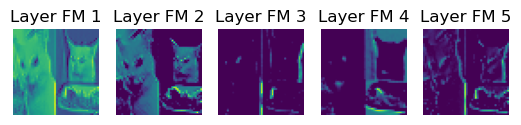

[Second Layer]


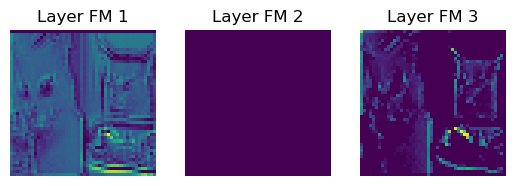

[Final Layer]


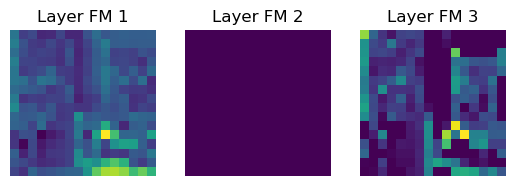

In [91]:
def print_featuremap(layer1, cols, layer_name):
    # 제목 출력
    print(f'[{layer_name} Layer]')

    # 그래프 그리기
    for idx in range(layer1.shape[0]):
        plt.subplot(1,cols,idx+1)
        plt.imshow(layer1[idx].detach().numpy())
        plt.title(f'Layer FM {idx+1}')
        plt.axis('off')
    plt.tight_layout
    plt.show()

print_featuremap(relu1, 5, 'Fist')
print_featuremap(relu2, 3, 'Second')
print_featuremap(mp1, 3, 'Final')
